Import Libraries

In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cuda:0


Load Dataset

In [2]:
# Dataset paths and epochs
EPOCHS = 60
data_dir = "input/segmented_chest_xray"
mask_dir = "input/segment_masks"
TEST = 'test'
TRAIN = 'train'
VAL = 'val'

Data Preprocessing and Augmentation

In [3]:
# Data Preprocessing and Augmentation
def data_transforms(phase):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale image to RGB
        transforms.ToTensor(),
        transforms.Normalize([0.4627, 0.4627, 0.4627], [0.1670, 0.1670, 0.1670])  # Use calculated mean and std
    ])
    return transform

def mask_transforms():
    return transforms.Compose([
        transforms.ToTensor()
    ])

In [4]:
# Custom Dataset class to load images and masks
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        for class_name in os.listdir(image_dir):
            class_image_dir = os.path.join(image_dir, class_name)
            class_mask_dir = os.path.join(mask_dir, class_name)
            for fname in os.listdir(class_image_dir):
                self.image_paths.append(os.path.join(class_image_dir, fname))
                self.mask_paths.append(os.path.join(class_mask_dir, fname))
        
        # 클래스 이름을 추출하기 위한 예제 이미지 경로 사용
        self.classes = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0).float()  # 이진화
        
        # 클래스 라벨 추출
        label = os.path.basename(os.path.dirname(image_path))
        label_idx = self.classes.index(label)
        
        return image, label_idx, mask

In [5]:
# Create datasets and dataloaders
train_dataset = CustomDataset(os.path.join(data_dir, TRAIN), os.path.join(mask_dir, TRAIN), data_transforms(TRAIN), mask_transforms())
val_dataset = CustomDataset(os.path.join(data_dir, VAL), os.path.join(mask_dir, VAL), data_transforms(VAL), mask_transforms())
test_dataset = CustomDataset(os.path.join(data_dir, TEST), os.path.join(mask_dir, TEST), data_transforms(TEST), mask_transforms())

dataloaders = {
    TRAIN: DataLoader(train_dataset, batch_size=4, shuffle=True),
    VAL: DataLoader(val_dataset, batch_size=1, shuffle=True),
    TEST: DataLoader(test_dataset, batch_size=1, shuffle=True)
}

# Get the sizes of the datasets
dataset_sizes = {x: len(dataloaders[x].dataset) for x in [TRAIN, VAL, TEST]}
class_names = train_dataset.classes

In [6]:
# 맞춤 손실 함수 정의
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets, masks):
        loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        loss = loss * masks  # 마스크 적용
        return loss.mean()

# 맞춤 손실 함수 사용 예시
criterion = MaskedCrossEntropyLoss()

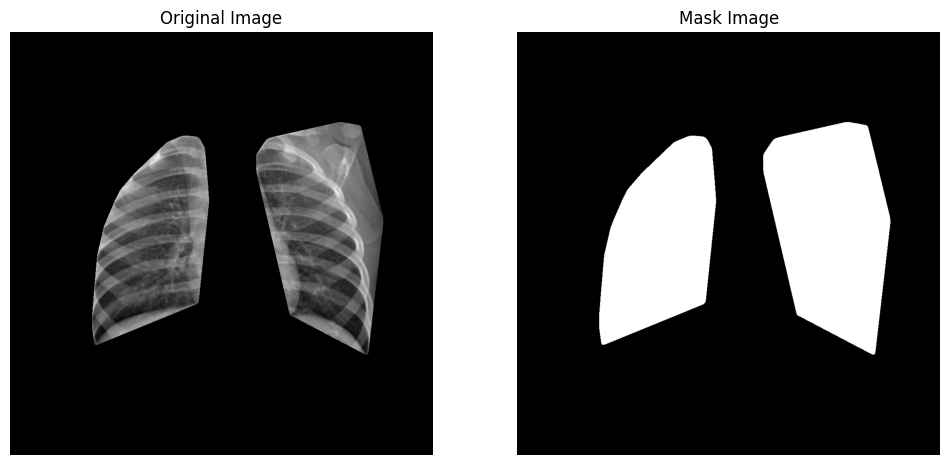

In [7]:
# 시각화를 위해 역정규화 함수 정의
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 샘플 이미지 로드 및 시각화
inputs, labels, masks = next(iter(dataloaders[TRAIN]))
input_image = inputs[0]
mask = masks[0]

# 원본 이미지 역정규화
input_image = denormalize(input_image, [0.4627, 0.4627, 0.4627], [0.1670, 0.1670, 0.1670])

# 원본 이미지와 마스크 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
axes[0].imshow(input_image.permute(1, 2, 0).numpy(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# 마스크 이미지
axes[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title("Mask Image")
axes[1].axis("off")

plt.show()

In [9]:
# 학습 시 마스크 적용
def train_model_with_mask(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels, masks = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels, masks)

                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == VAL and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"Model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")

        # 스케줄러 스텝
        scheduler.step()

    print('Best val Loss: {:4f}'.format(best_val_loss))

    # 베스트 모델 저장
    model.load_state_dict(best_model_wts)
    best_model_save_path = os.path.join('models', 'best_pneumonia_model.pth')
    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
    torch.save(model.state_dict(), best_model_save_path)
    print(f'Best model saved to {best_model_save_path}')

    return model


In [10]:
# Load the Pretrained Model
model_pre = models.resnet152(pretrained=True)
model_pre.load_state_dict(torch.load("/home/shun2959/test/진폐증copy/models/resnet152-394f9c45.pth"))
for param in model_pre.parameters():
    param.requires_grad = False

# ResNet152의 마지막 fully connected layer를 변경
num_features = model_pre.fc.in_features
model_pre.fc = nn.Linear(num_features, len(class_names))
print(model_pre)

/opt/anaconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# 모델, 손실 함수, 옵티마이저, 스케줄러 설정
model_pre = model_pre.to(device)
optimizer = optim.Adam(model_pre.fc.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

In [12]:
# Train Phase
model_pre = train_model_with_mask(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/60


RuntimeError: expand(torch.cuda.FloatTensor{[4, 1, 1024, 1024]}, size=[4]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (4)

폐 영역 분리 후 분리된 이미지로 추론 시키기

In [ ]:
import cv2
import numpy as np

# 후처리 함수
def postprocess_mask(mask):
    # OpenCV로 마스크 후처리
    mask = (mask * 255).astype(np.uint8)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # 큰 윤곽선 두 개만 남기기
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 큰 두 개의 윤곽선만 남기기
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    new_mask = np.zeros_like(mask)
    for contour in contours:
        cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # 구멍 메우기
    new_mask = cv2.morphologyEx(new_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    return new_mask


In [ ]:
from PIL import Image

# 폐영역 분리 이미지를 위한 함수
def create_segmented_image(img_path):
    origin = Image.open(img_path).convert("L")
    origin_resized = torchvision.transforms.functional.resize(origin, (512, 512))
    origin_tensor = torchvision.transforms.functional.to_tensor(origin_resized) - 0.5
    
    with torch.no_grad():
        origin_tensor = torch.stack([origin_tensor]).to(device)
        out = seg_model(origin_tensor)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        mask = torch.argmax(softmax, dim=1).squeeze(0).cpu().numpy()

    # 마스크 후처리
    postprocessed_mask = postprocess_mask(mask)
    
    # 후처리된 마스크로 분리된 이미지 생성
    mask_resized = Image.fromarray(postprocessed_mask).resize(origin.size, Image.NEAREST)
    segmented_img = Image.composite(origin, Image.new('L', origin.size), mask_resized)
    
    return segmented_img


In [ ]:
# 모델 로드 후 평가 모드로 전환
model_pre.load_state_dict(torch.load('models/best_pneumonia_model.pth'))
model_pre.to(device)
model_pre.eval()

In [ ]:
from src.res_model import ResNetUNet

# 폐 세그멘테이션 모델 불러오기
seg_model = ResNetUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)
seg_model.load_state_dict(torch.load('models/best_segmentation.pt'))
seg_model.to(device)
seg_model.eval()

In [26]:
# 폐영역 분리 이미지를 위한 함수
def create_segmented_image(img_path):
    origin = Image.open(img_path).convert("L")
    origin_resized = torchvision.transforms.functional.resize(origin, (512, 512))
    origin_tensor = torchvision.transforms.functional.to_tensor(origin_resized) - 0.5
    
    with torch.no_grad():
        origin_tensor = torch.stack([origin_tensor]).to(device)
        out = seg_model(origin_tensor)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        mask = torch.argmax(softmax, dim=1).squeeze(0).cpu().numpy()

    mask_resized = Image.fromarray((mask * 255).astype(np.uint8)).resize(origin.size, Image.NEAREST)
    segmented_img = Image.composite(origin, Image.new('L', origin.size), mask_resized)
    
    return segmented_img

In [23]:
# Evaluate Model Performance
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []
    original_images = []
    segmented_images = []

    with torch.no_grad():
        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            # 각 이미지를 순차적으로 가져오기 위해 인덱스 사용
            original_img_path = os.path.join("input/chest_xray", TEST, class_names[labels.item()], os.listdir(os.path.join("input/chest_xray", TEST, class_names[labels.item()]))[i])
            original_img = Image.open(original_img_path).convert("L")
            segmented_img = create_segmented_image(original_img_path)
            
            inputs = data_transforms(TEST)(segmented_img).unsqueeze(0).to(device)
            labels = labels.to(device)

            true_labels.append(labels.item())
            original_images.append(original_img)
            segmented_images.append(segmented_img)
            input_images.append(inputs)

            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        acc = running_correct / running_total

    return true_labels, pred_labels, input_images, original_images, segmented_images, running_correct, running_total, acc


In [24]:
# Testing Phase
true_labels, pred_labels, input_images, original_images, segmented_images, running_correct, running_total, acc = test_model()

# Results
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x = 0
for i in range(3):
    for j in range(3):
        # Original Image
        axes[i, j * 2].imshow(original_images[x], cmap='gray')
        axes[i, j * 2].set_title(f"Original Image\nActual: {class_names[true_labels[x]]}")
        axes[i, j * 2].axis('off')
        
        # Segmented Image
        segmented_img = segmented_images[x]
        inp = input_images[x].squeeze()
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j * 2 + 1].imshow(inp)
        title = f"Predicted: {class_names[pred_labels[x]]}\nActual: {class_names[true_labels[x]]}"
        color = 'green' if pred_labels[x] == true_labels[x] else 'red'
        axes[i, j * 2 + 1].set_title(title, color=color)
        axes[i, j * 2 + 1].axis('off')
        
        x += 1

plt.show()
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

TypeError: 'collections.OrderedDict' object is not callable